In [1]:
import os
import sys
import numpy as np
import pandas as pd
sys.path.append(os.path.abspath("../../nnets"))
from graph import Node, Parameter, display_chain, reshape_grad

# Read in our data, and fill missing values
data = pd.read_csv("../../data/clean_weather.csv", index_col=0)
data = data.ffill()

x = data[:10][["tmax", "tmin", "rain"]].to_numpy()
y = data[:10][["tmax_tomorrow"]].to_numpy()

In [2]:
class MatMul(Node):
    def forward(self, x, w):
        return x @ w

    def backward(self, grad):
        x, w = self.cache
        return grad @ w.T, x.T @ grad

class Add(Node):
    def forward(self, x, b):
        return x + b

    def backward(self, grad):
        return grad, grad

class MSE(Node):
    def forward(self, pred, actual):
        return pred, (pred - actual) ** 2

    def backward(self, grad):
        pred, actual = self.cache
        return 2 * (pred - actual)

class Pow(Node):
    def forward(self, x, exponent):
        return x ** exponent

    def backward(self, grad):
        x, exponent = self.cache
        return grad * exponent * x ** (exponent - 1)

class Subtract(Node):
    def forward(self, x, y):
        return x - y

    def backward(self, grad):
        return grad, -grad

class Relu(Node):
    def forward(self, x):
        return np.maximum(x, 0)

    def backward(self, grad):
        x = self.cache[0]
        grad[x < 0] = 0
        return grad

In [3]:
w1 = np.random.rand(3, 3)
b1 = np.random.rand(3)
w2 = np.random.rand(3,1)
b2 = np.random.rand(1)

l1 = x @ w1 + b1
l1_activated = np.maximum(l1, 0)
l2 = l1_activated @ w2 + b2

loss = 2 * (l2 - y)

l2_w_grad = l1_activated.T @ loss
l2_b_grad = loss.sum(axis=0)

l1_grad = loss @ w2.T
l1_grad[l1 < 0] = 0

l1_w_grad = x.T @ l1_grad
l1_b_grad = l1_grad.sum(axis=0)

In [4]:
l1_w_grad

array([[5.84405065e+03, 2.35229698e+04, 2.84577548e+02],
       [4.55485139e+03, 1.83337959e+04, 2.21799659e+02],
       [8.92341412e+00, 3.59177587e+01, 4.34527944e-01]])

In [5]:
X = Parameter(x, desc="X", needs_grad=False)
Y = Parameter(y, desc="y", needs_grad=False)

w1_param = Parameter(w1, desc="W1")
b1_param = Parameter(b1, desc="b1")

matmul1 = MatMul(X, w1_param, out="X @ W1")
add1 = Add(matmul1, b1_param, out="Z1")

layer1 = Relu(add1, out="A1")

w2_param = Parameter(w2, desc="W2")
b2_param = Parameter(b2, desc="b2")
matmul2 = MatMul(layer1, w2_param, out="Z1 @ W2")
add2 = Add(matmul2, b2_param, out="Z2")

sub = Subtract(add2, Y, out="p - y")
square = Parameter(2, desc="2", needs_grad=False)
pow = Pow(sub, square, out="L")
loss = pow.apply_fwd()

In [6]:
mse = MSE(add2, Y, out="L")
pred, loss_mse = mse.apply_fwd()

np.allclose(loss, loss_mse)

True

In [7]:
np.allclose(l2, pred)

True

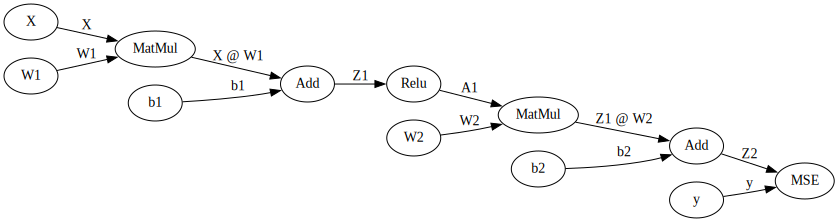

In [8]:
mse.generate_graph()

In [9]:
mse.zero_grad()
mse.apply_bwd(1)

np.allclose(l1_w_grad, w1_param.grad)

True

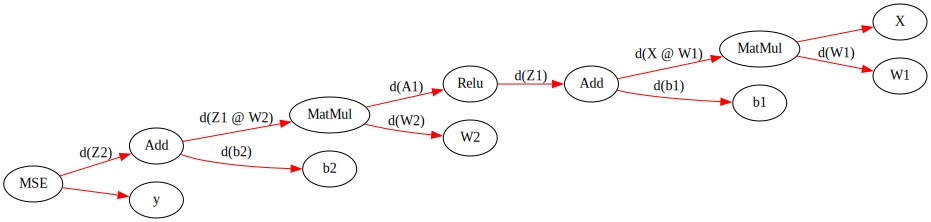

In [10]:
mse.generate_graph(backward=True)

In [11]:
mse.generate_derivative_chains()
display_chain(b1_param.display_partial_derivative())

<IPython.core.display.Latex object>

In [25]:
class Exp(Node):
    def forward(self, x):
        return np.exp(x)

    def backward(self, grad):
        x = self.cache[0]
        return np.exp(x) * grad

class Max(Node):
    def forward(self, x):
        return np.max(x, axis=-1).reshape(-1,1)

    def backward(self, grad):
        x = self.cache[0]
        max = np.max(x, axis=-1).reshape(-1,1)
        grad[x < max] = 0
        return grad

class Sum(Node):
    def forward(self, x):
        return np.sum(x, axis=-1).reshape(-1,1)

    def backward(self, grad):
        x = self.cache[0]
        return np.ones_like(x) * grad.reshape(-1,1) / x.shape[1]

class Multiply(Node):
    def forward(self, x, y):
        return x * y

    def backward(self, grad):
        x, y = self.cache
        x_grad = reshape_grad(x, y * grad)
        y_grad = reshape_grad(y, x * grad)
        return x_grad, y_grad

In [26]:
X = Parameter(x / 100, desc="X", needs_grad=True)

max = Max(X, out="max(e^X)")
normalized = Subtract(X, max, out="e^X - max(e^X)")
raised = Exp(normalized, out="e^X")
summed = Sum(raised, out="sum(e^X)")

negative_one = Parameter(-1, desc="-1", needs_grad=False)
inverted = Pow(summed, negative_one, out="1 / sum(e^X)")
softmax = Multiply(raised, inverted, out="softmax(X)")

output = softmax.apply_fwd()
output

array([[0.42962479, 0.33459212, 0.23578308],
       [0.40442997, 0.35512811, 0.24044193],
       [0.41014109, 0.34602161, 0.2438373 ],
       [0.4111386 , 0.34686317, 0.24199822],
       [0.41014109, 0.34602161, 0.2438373 ],
       [0.40105058, 0.35569995, 0.24324947],
       [0.39865228, 0.36434075, 0.23700697],
       [0.39920551, 0.37221675, 0.22857774],
       [0.39279252, 0.3773909 , 0.22981658],
       [0.4003332 , 0.3732682 , 0.22639861]])

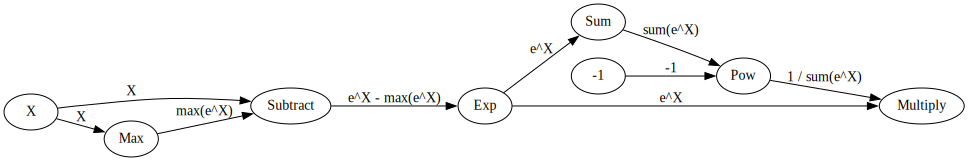

In [27]:
softmax.generate_graph()

In [28]:
softmax.zero_grad()
softmax.apply_bwd(output)

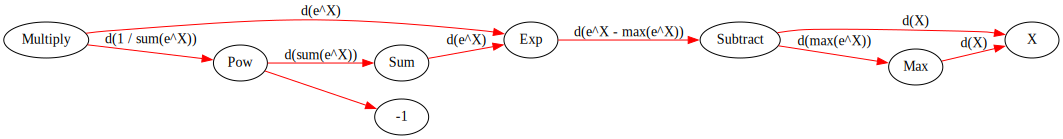

In [29]:
softmax.generate_graph(backward=True)

In [30]:
softmax.generate_derivative_chains()
display_chain(X.display_partial_derivative())

<IPython.core.display.Latex object>

In [31]:
X.grad

array([[0.        , 0.07267936, 0.02791878],
       [0.        , 0.08498126, 0.02996178],
       [0.        , 0.07966127, 0.03122   ],
       [0.        , 0.08008809, 0.03049843],
       [0.        , 0.07966127, 0.03122   ],
       [0.        , 0.08543504, 0.03107221],
       [0.        , 0.09050007, 0.02869213],
       [0.        , 0.0951004 , 0.02556833],
       [0.        , 0.09845464, 0.02604008],
       [0.        , 0.09567516, 0.02477885]])

In [19]:
def softmax_grad_func(x):
    # Reshape the 1-d softmax to 2-d so that np.dot will do the matrix multiplication
    s = x.reshape(-1,1)
    flat_deriv = np.diagflat(s) - np.dot(s, s.T)
    return np.sum(flat_deriv, axis=-1).reshape(x.shape)

def softmax_func(z):
    z -= np.max(z)
    sm = np.exp(z) / np.sum(np.exp(z), axis=-1).reshape(-1,1)
    return sm

sm_func_output = softmax_func(x/100)
np.allclose(output, sm_func_output)

True

In [20]:
softmax_grad = softmax_grad_func(sm_func_output)

softmax_grad

array([[-3.86662312, -3.01132912, -2.12204776],
       [-3.63986971, -3.19615296, -2.16397733],
       [-3.6912698 , -3.11419446, -2.19453574],
       [-3.70024742, -3.12176856, -2.17798402],
       [-3.6912698 , -3.11419446, -2.19453574],
       [-3.60945519, -3.20129957, -2.18924524],
       [-3.58787051, -3.27906675, -2.13306274],
       [-3.59284961, -3.34995077, -2.05719962],
       [-3.53513265, -3.39651811, -2.06834924],
       [-3.60299876, -3.35941378, -2.03758746]])